In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.applications.resnet50 import ResNet50
import matplotlib.pyplot as plt

In [2]:
# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession

# config = ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.5
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)

In [3]:
BATCH_SIZE = 64
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=25

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/tomato_train",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 5000 files belonging to 10 classes.


In [5]:
class_names = dataset.class_names
class_names

['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

In [6]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(64, 256, 256, 3)
[0 8 3 4 0 6 8 7 1 0 2 0 4 9 3 6 1 2 0 8 4 7 2 7 0 5 6 7 4 5 0 0 5 4 3 7 4
 2 8 1 4 2 3 5 3 8 3 3 0 5 7 1 9 8 1 3 5 6 0 7 3 9 8 9]


In [7]:
len(dataset)

79

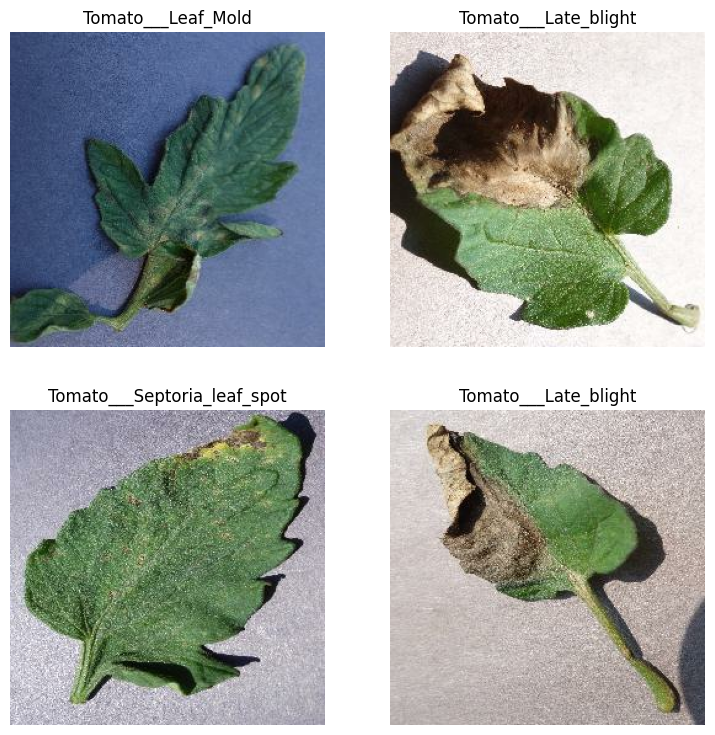

In [8]:
plt.figure(figsize=(9,9))
for image_batch, labels_batch in dataset.take(1):
    for i in range(4):
        ax = plt.subplot(2,2, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [9]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [10]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
# train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
# val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
# test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [11]:
model = models.Sequential()

In [12]:
pretrained_model=ResNet50(include_top=False,
                   input_shape=(256,256,3),
                   pooling='avg',classes=10,
                   weights='imagenet')

94765736/94765736 [==============================] - 0s 0us/step


In [13]:
for each_layer in pretrained_model.layers:
    each_layer.trainable=False

In [14]:
#pretrained_model.summary()

In [15]:
model.add(pretrained_model)

In [16]:
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 24641930 (94.00 MB)
Trainable params: 1054218 (4.02 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [18]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [19]:
history=model.fit(train_ds,validation_data=val_ds,epochs=25)

Epoch 1/25
63/63 [==============================] - 718s 529ms/step - loss: 0.9248 - accuracy: 0.7155 - val_loss: 0.3082 - val_accuracy: 0.9129
Epoch 2/25
63/63 [==============================] - 49s 535ms/step - loss: 0.3260 - accuracy: 0.8944 - val_loss: 0.1872 - val_accuracy: 0.9442
Epoch 3/25
63/63 [==============================] - 48s 513ms/step - loss: 0.1988 - accuracy: 0.9399 - val_loss: 0.1114 - val_accuracy: 0.9847
Epoch 4/25
63/63 [==============================] - 48s 515ms/step - loss: 0.1442 - accuracy: 0.9570 - val_loss: 0.0961 - val_accuracy: 0.9844
Epoch 5/25
63/63 [==============================] - 48s 517ms/step - loss: 0.1022 - accuracy: 0.9730 - val_loss: 0.0867 - val_accuracy: 0.9668
Epoch 6/25
63/63 [==============================] - 50s 561ms/step - loss: 0.0787 - accuracy: 0.9814 - val_loss: 0.0604 - val_accuracy: 0.9955
Epoch 7/25
63/63 [==============================] - 50s 536ms/step - loss: 0.0629 - accuracy: 0.9867 - val_loss: 0.0359 - val_accuracy: 0.995

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

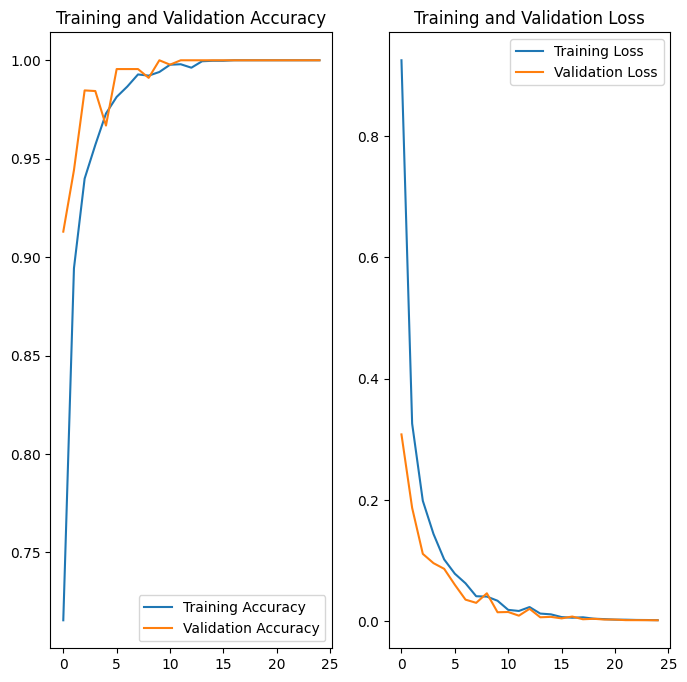

In [21]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Tomato___Septoria_leaf_spot
2/2 [==============================] - 4s 27ms/step
predicted label: Tomato___Septoria_leaf_spot


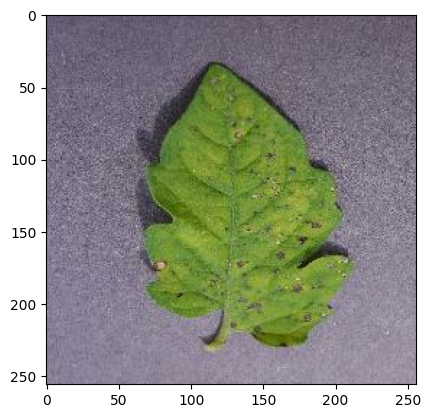

In [22]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [23]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 21ms/step


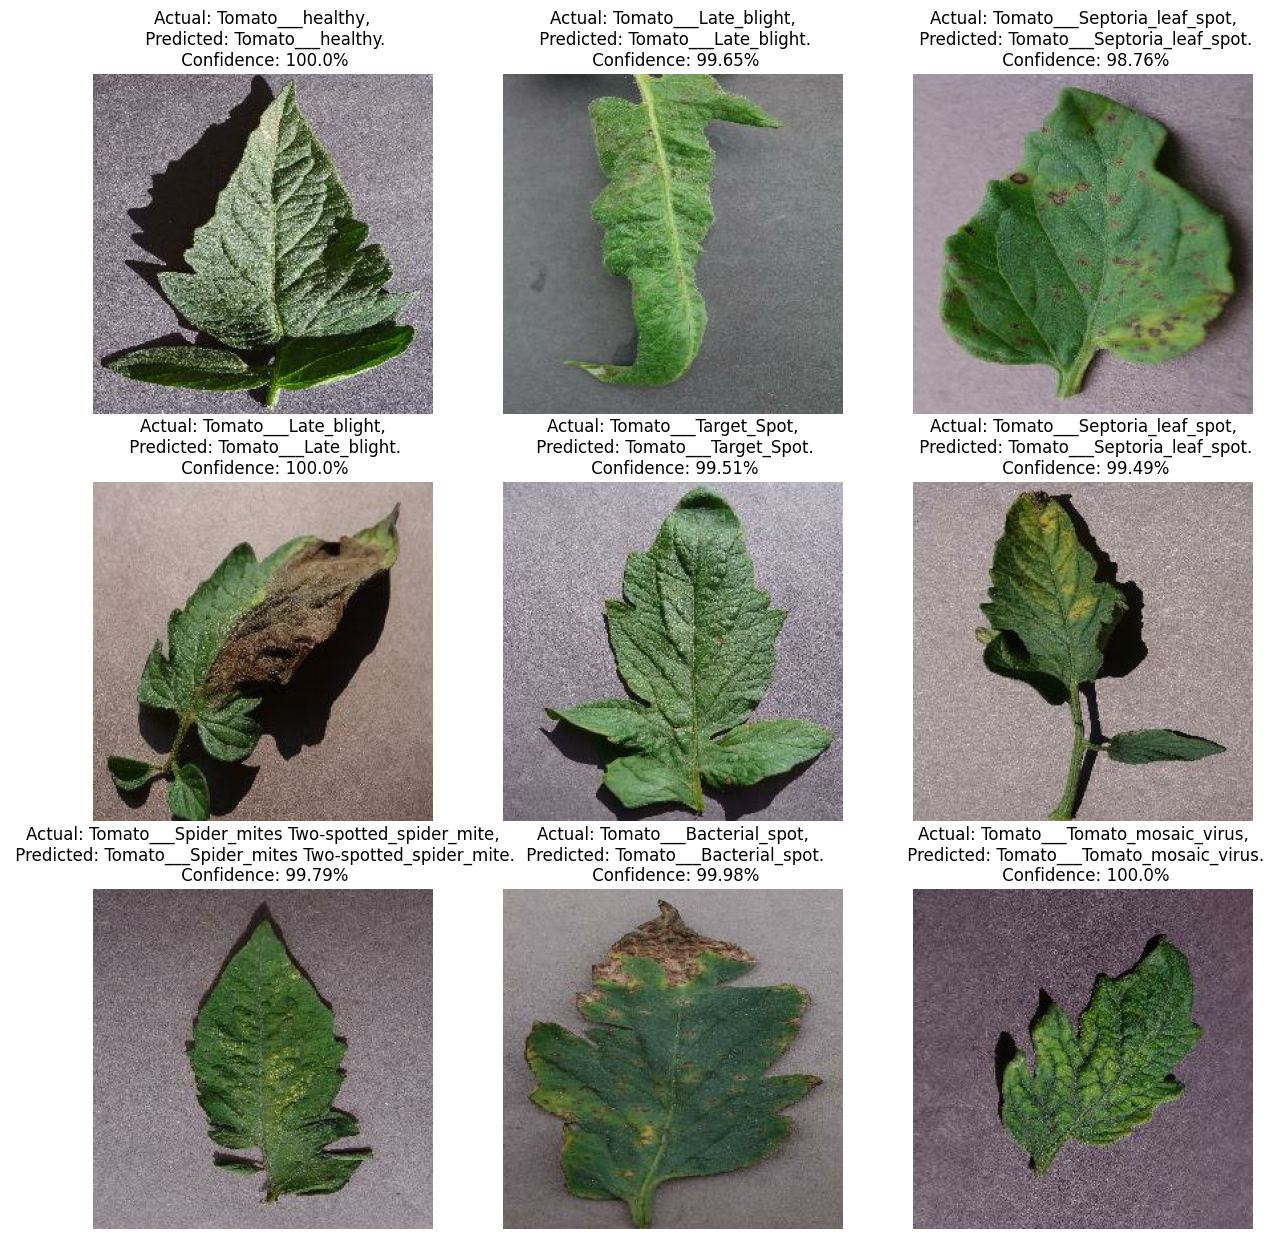

In [24]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [25]:
model.save("tomatoes_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
